In [1]:
from IPython.display import HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU

In [3]:
import warnings
warnings.filterwarnings("ignore")

### Data

In [4]:
data = pd.read_csv('data/train.csv')
data['dt'] = pd.to_datetime(data['dt'])

In [5]:
pivot_data = pd.pivot_table(data, 
                            values='target', 
                            index='dt', 
                            columns='id', 
                            aggfunc='sum', 
                            fill_value=None) 

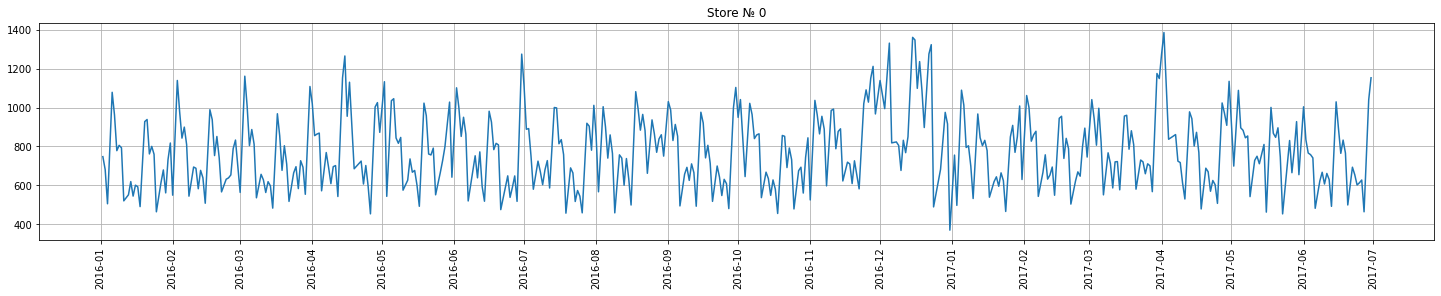

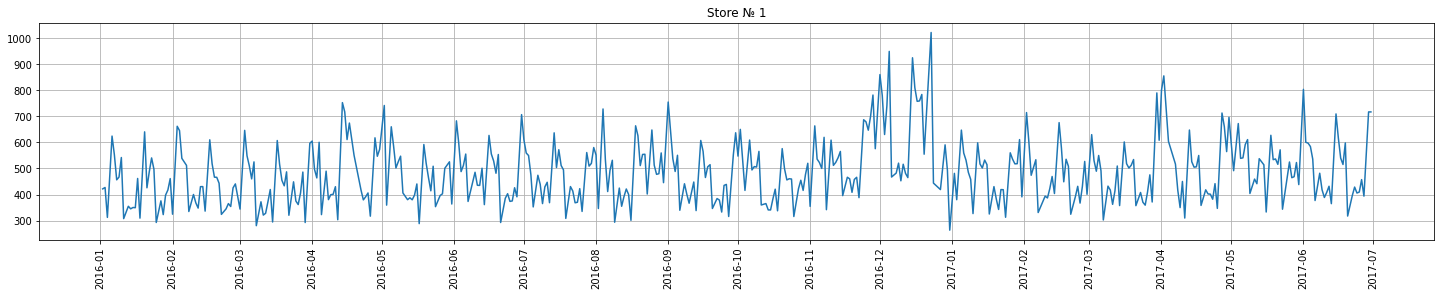

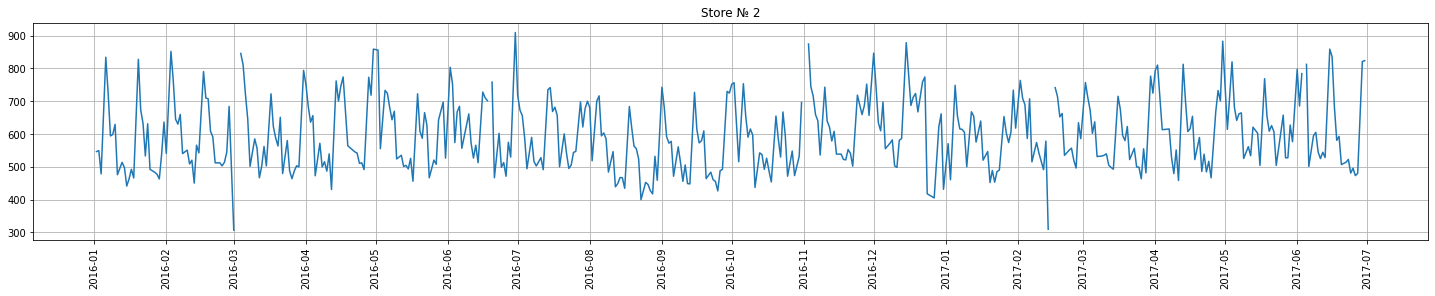

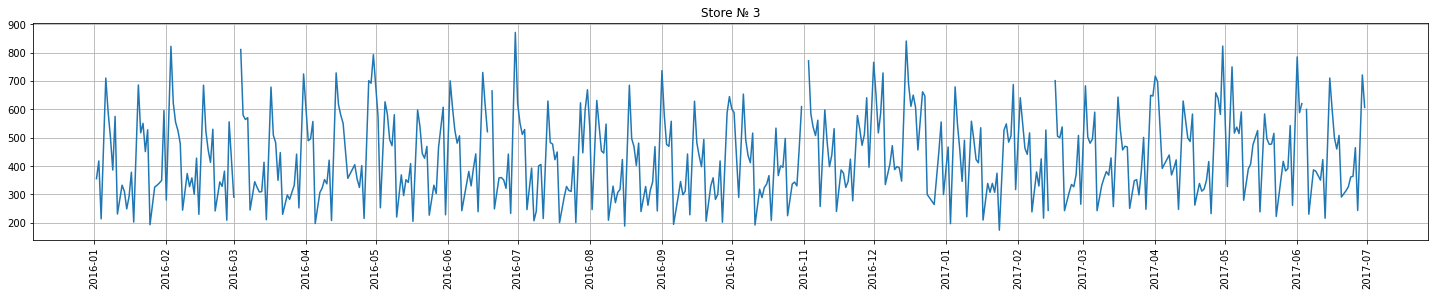

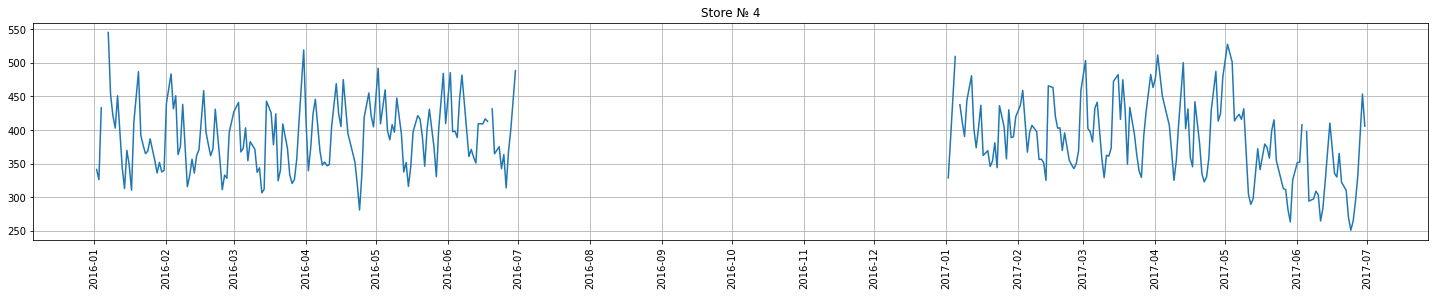

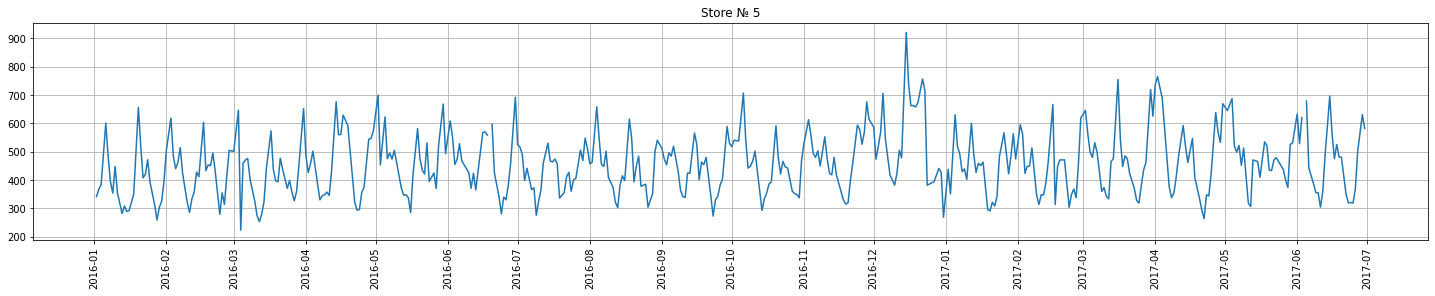

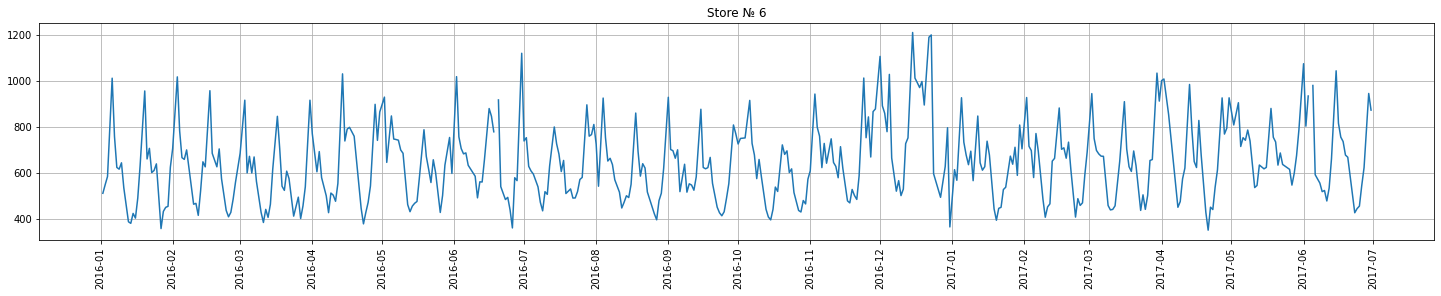

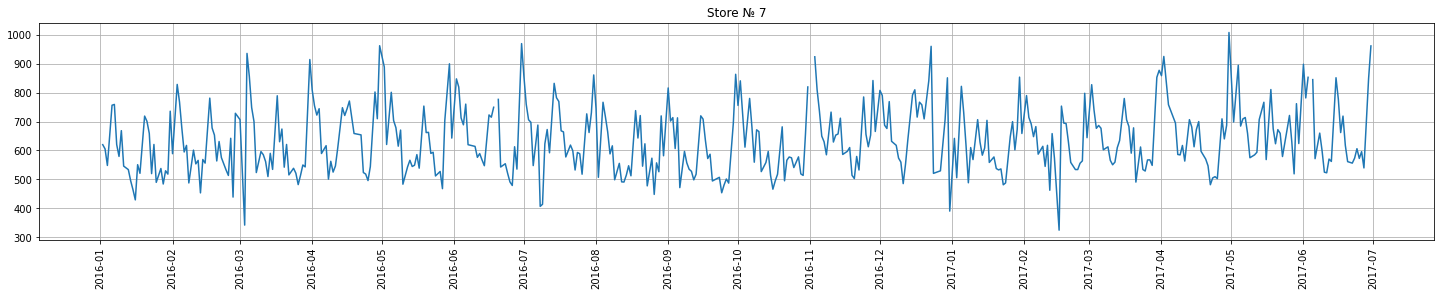

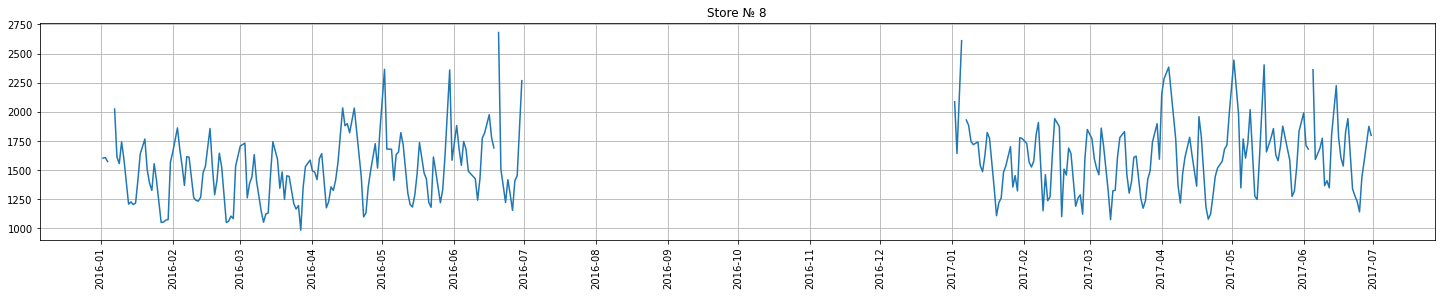

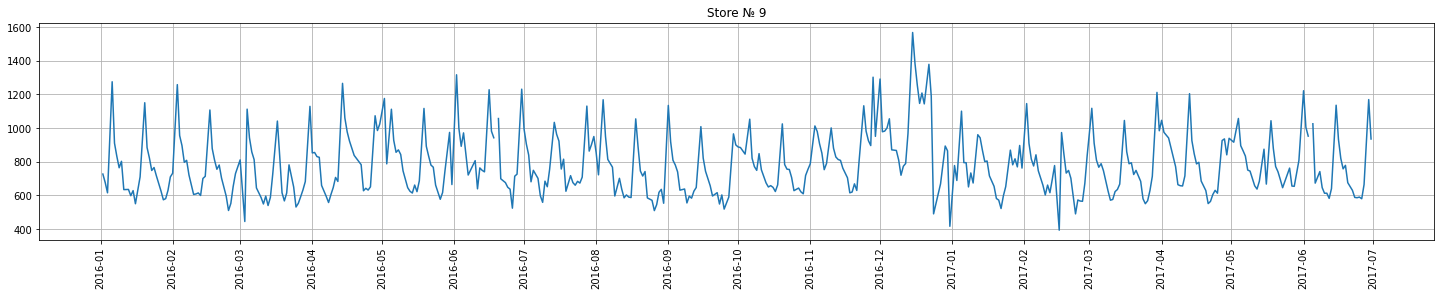

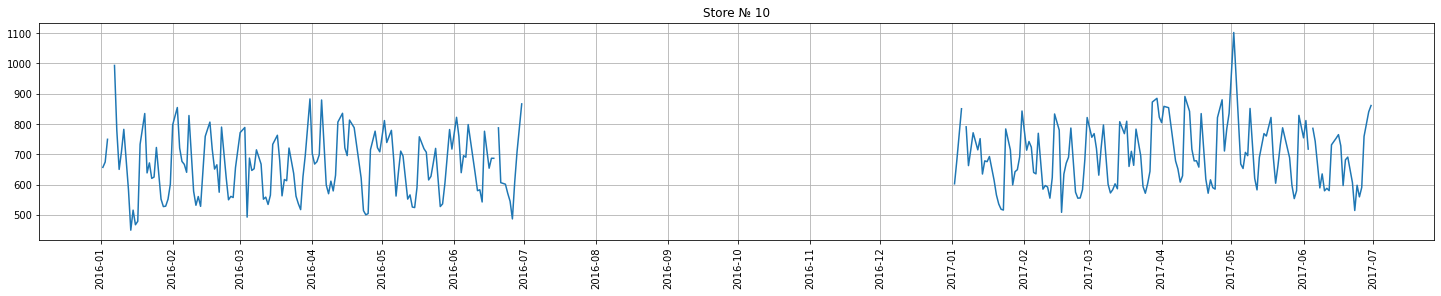

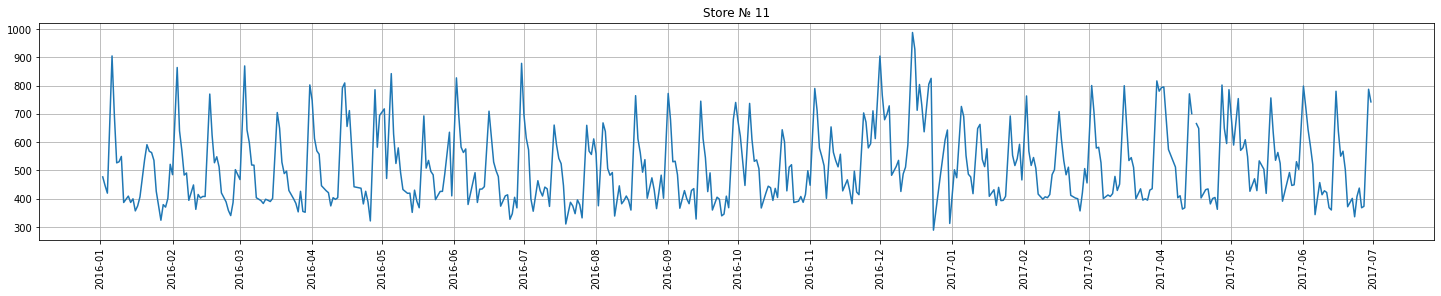

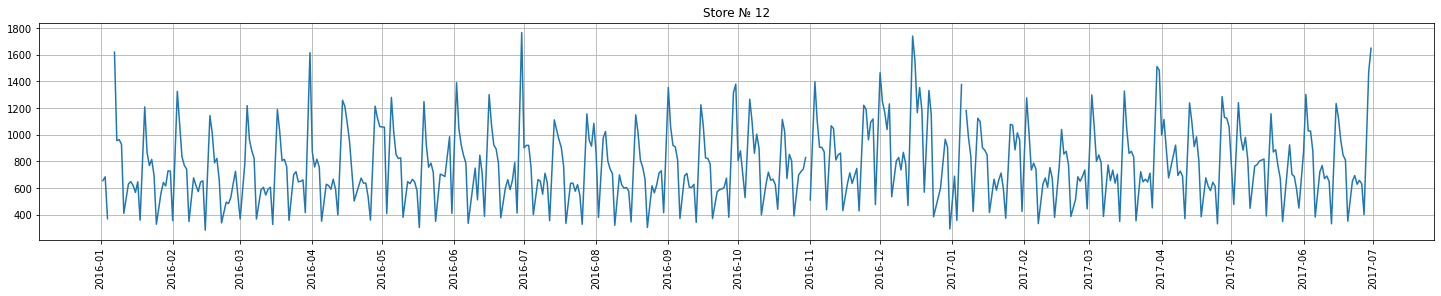

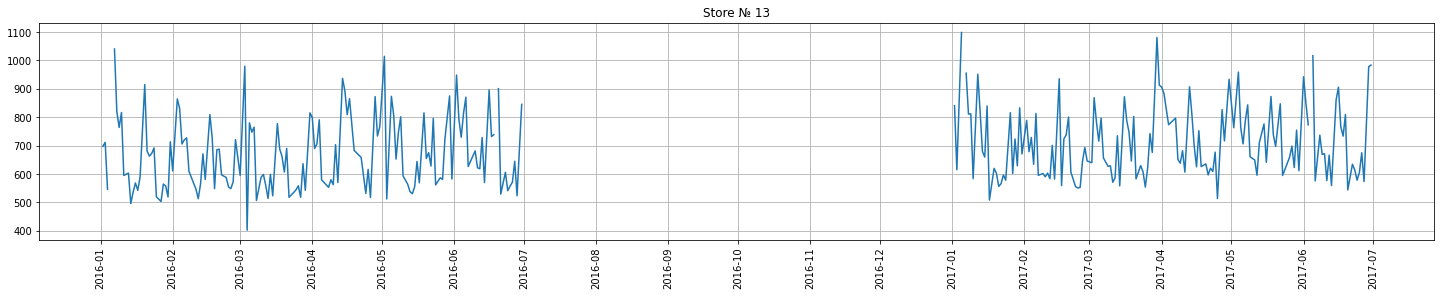

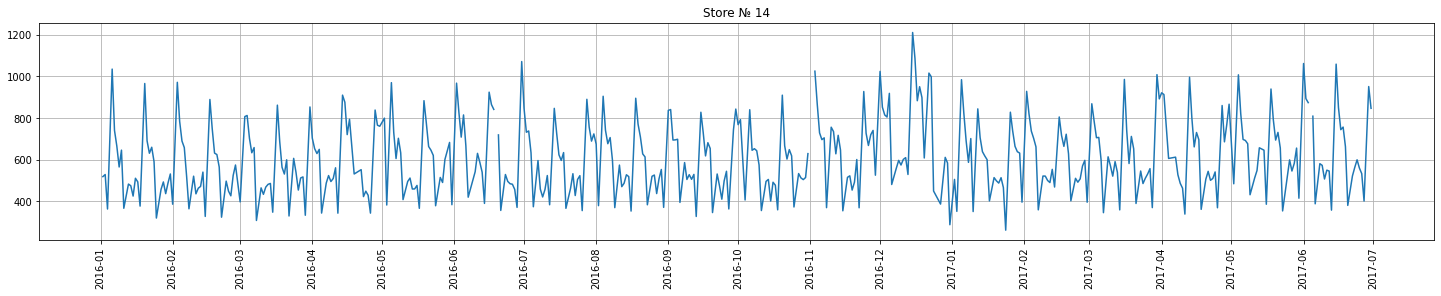

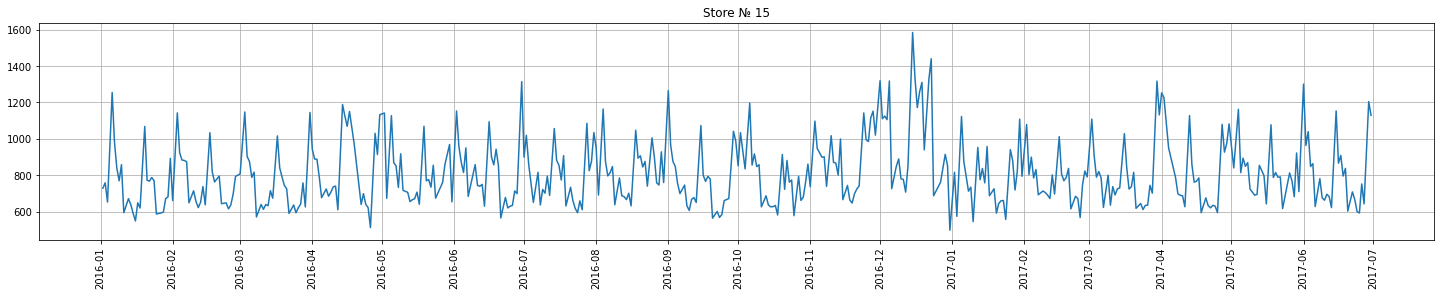

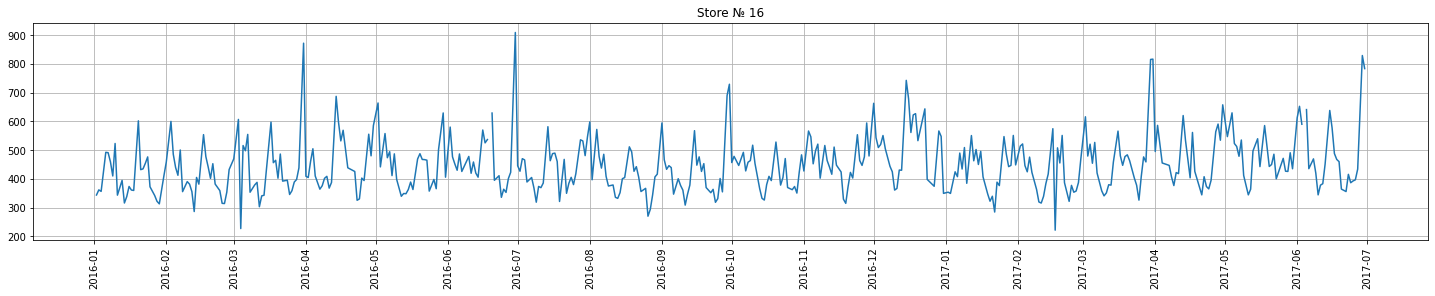

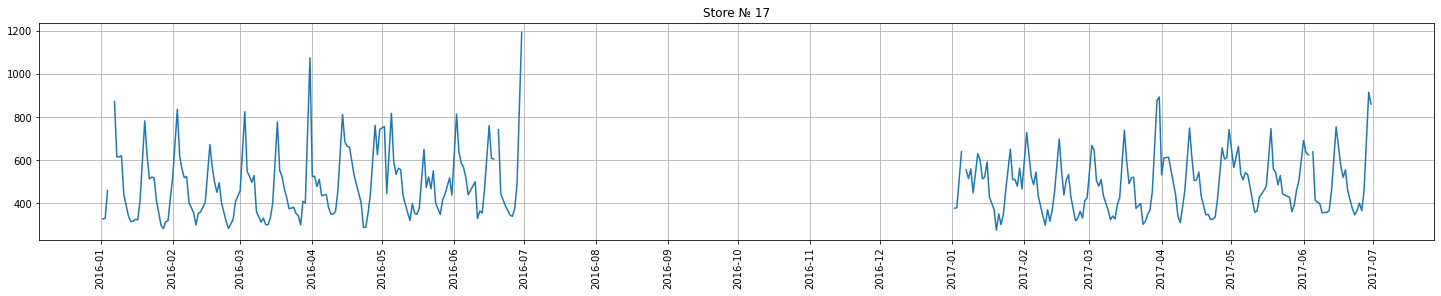

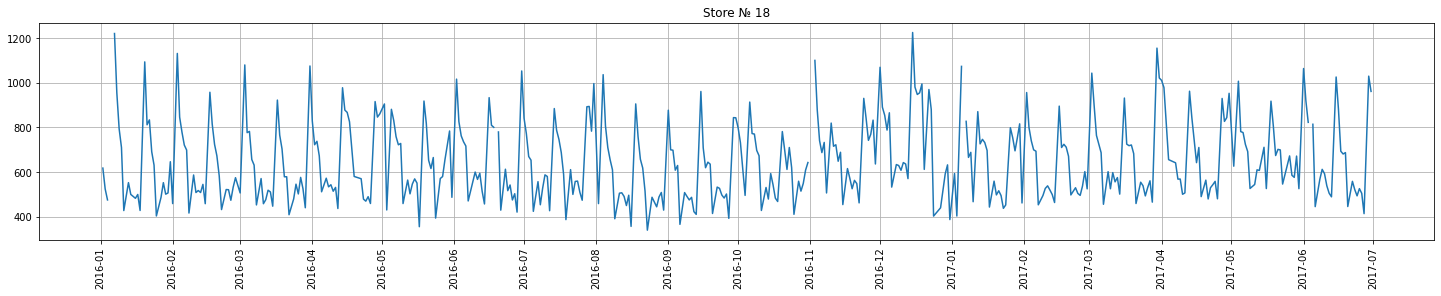

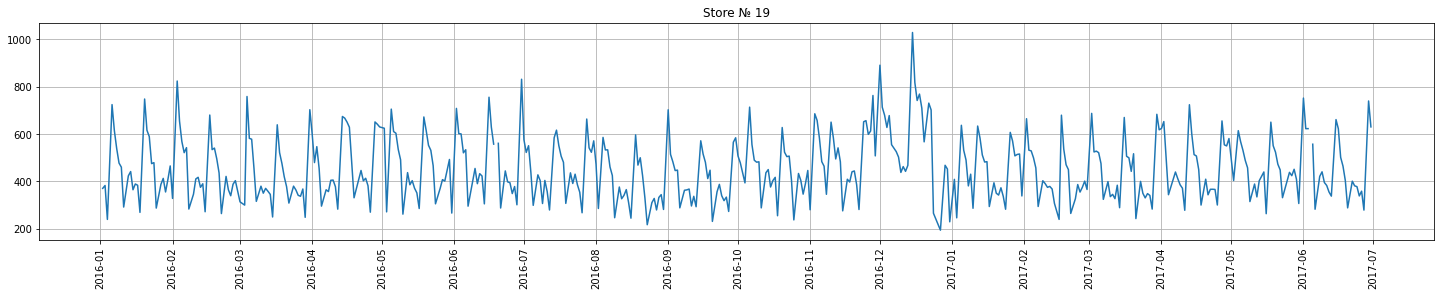

In [6]:
for store in pivot_data.columns:
    fig, ax = plt.subplots(figsize=(25, 4))
    ax.plot(pivot_data[store], label = store)
    ax.xaxis.set_major_locator(md.MonthLocator())
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'Store № {store}')
    ax.grid()

1) Missing values for stores with ID 4, 8, 10, 13, 17 -- no data for 6 months -- from 07/01/2016 to 01/01/2017; \
2) Slight trend in data; \
3) Weekly seasonality; \
4) New Year's sales growth \
5) Sales growth in the first week of the quarter.

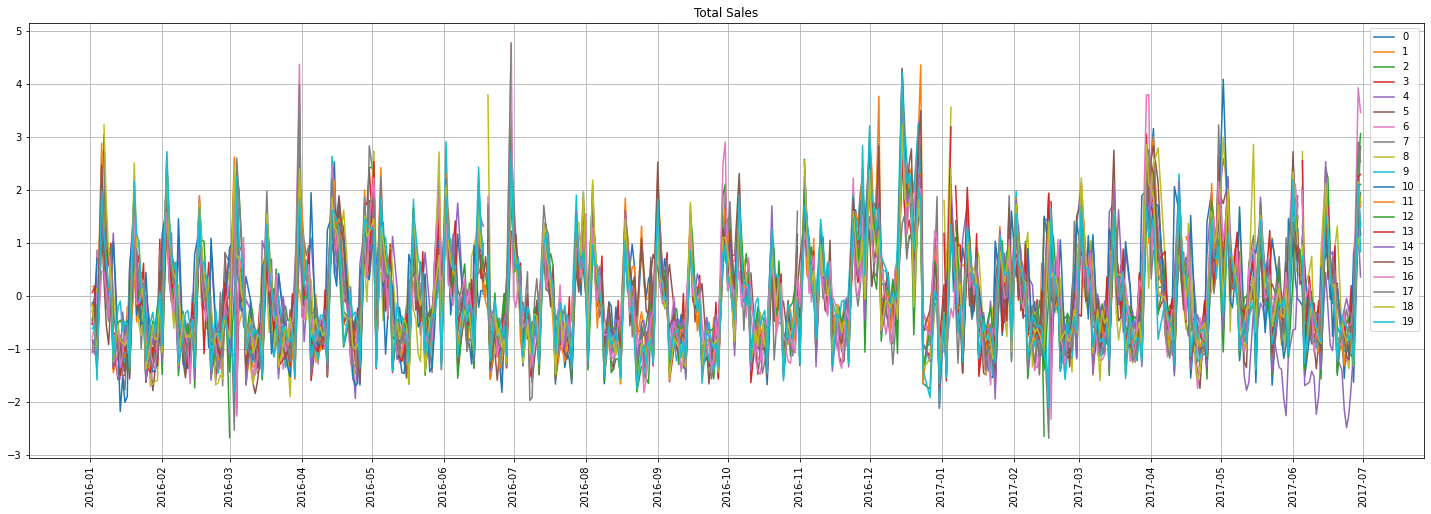

In [50]:
# in one plot

STANDARDIZATION = True

fig, ax = plt.subplots(figsize=(25, 8))

if STANDARDIZATION:
    for store in pivot_data.columns:
        ax.plot((pivot_data[store] - pivot_data[store].mean()) / pivot_data[store].std(), label = store)
    ax.xaxis.set_major_locator(md.MonthLocator())
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'Total Sales')
    ax.grid()
    ax.legend();
else:
    for store in pivot_data.columns:
        ax.plot(pivot_data[store], label = store)
    ax.xaxis.set_major_locator(md.MonthLocator())
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'Total Sales')
    ax.grid()
    ax.legend();



In [38]:
def create_calendar_vars(df, date_col):

    def week_of_month(dt):
        first_day = dt.replace(day=1)
        dom = dt.day
        adjusted_dom = dom + first_day.weekday()
        return int(np.ceil(adjusted_dom / 7.0))

    df_ = df.copy()
    df_['year'] = df_[date_col].dt.year
    df_['quarter'] = df_[date_col].dt.quarter
    df_['month'] = df_[date_col].dt.month
    df_['dayofyear'] = df_[date_col].dt.dayofyear
    df_['dayofmonth'] = df_[date_col].dt.day
    df_['dayofweek'] = df_[date_col].dt.dayofweek
    df_['week'] = df_[date_col].dt.isocalendar().week 
    df_['week'] = df_['week'].astype('int')
    df_['is_weekend'] = pd.Series(df_[date_col]).apply(lambda x : x.weekday() in [5, 6]).values 
    df_['is_weekend'] = df_['is_weekend'].astype('category')
    df_['week_of_month'] = pd.Series(df_[date_col]).apply(week_of_month).values
    df_['week_of_month'] = df_['week_of_month'].astype('int')
    
    return df_

In [39]:
column = 19
tmp0 = pivot_data[column].reset_index(drop=False)
tmp0 = create_calendar_vars(tmp0, date_col ='dt')

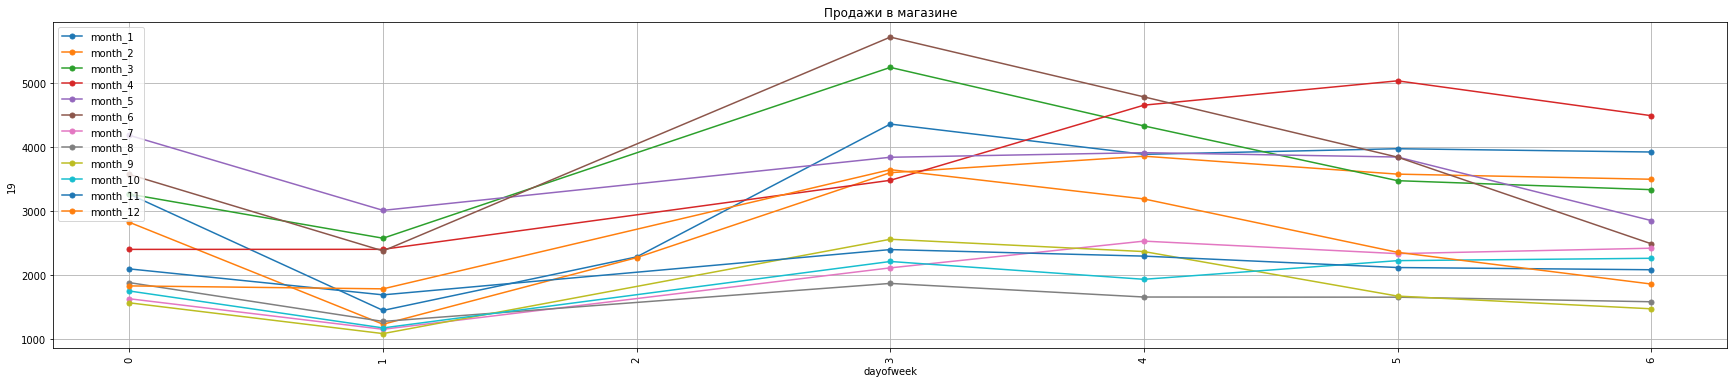

In [53]:
# groupby and granularity

# Сезонный цикл
groupby_column = 'month' # 'year', 'quarter', 'month', 'dayofyear', 'dayofmonth', 'dayofweek', 'week', 'is_weekend', 'week_of_month'
# Частота ряда
granularity_column = 'dayofweek'# 'year', 'quarter', 'month', 'dayofyear', 'dayofmonth', 'dayofweek', 'week', 'is_weekend', 'week_of_month'
target_column = column

grouped_df = tmp0.groupby(groupby_column)

fig, ax = plt.subplots(figsize=(30, 6))
for name, group in grouped_df:
    group = group.groupby(granularity_column, as_index = False)[target_column].sum(
    ax.plot(group[granularity_column], group[target_column], marker = 'o', markersize=5 ,
            label= f'{groupby_column}_{name}')
ax.set_title(f'Продажи в магазине')
ax.set_xlabel(granularity_column)
ax.set_ylabel(target_column)
ax.legend()
ax.grid()
xticks = sorted(tmp0[granularity_column].unique().tolist())
ax.set_xticks(xticks, minor=False)

# ax.xaxis.set_major_locator(md.MonthLocator())
ax.xaxis.set_tick_params(rotation=90);

### Series Decompose

Вариант 1.

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

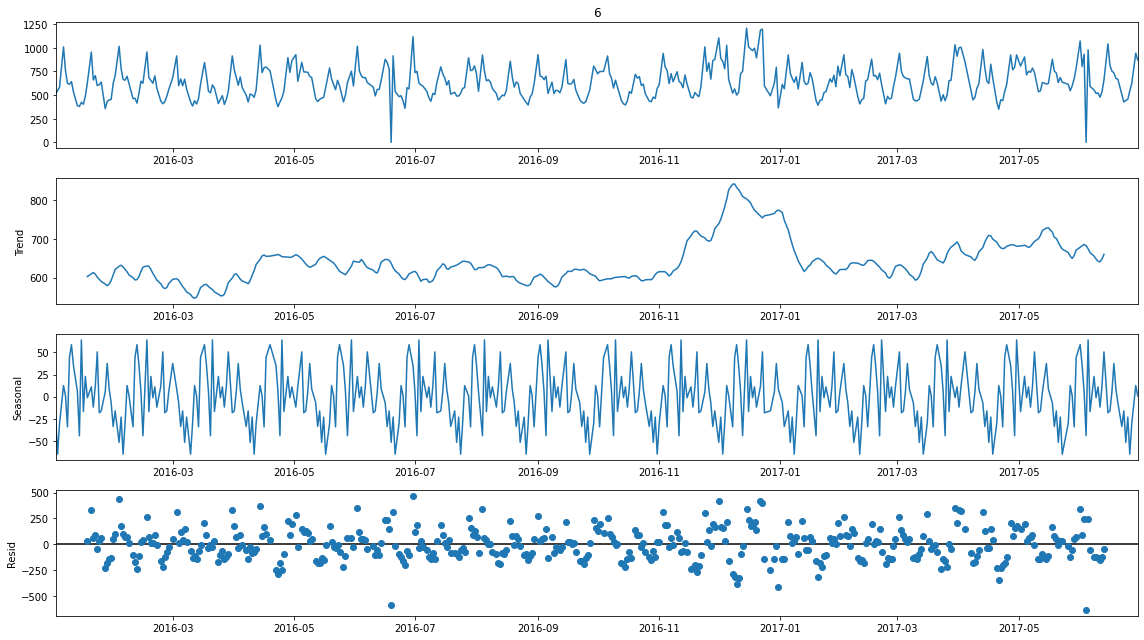

In [15]:
column = 6
series = pivot_data[column]
result = seasonal_decompose(series.fillna(0), 
                            model= 'additive', #'additive', 'multiplicative',
                            period=28)

fig = result.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

Несколько типов сезонностей: \
1. Недельная сезонность
2. Месячная сезонность (28-дневная)
3. Годовая сезонность.

Вариант 2.

In [16]:
from scipy.signal import savgol_filter

In [17]:
trend = savgol_filter(series, 25, 1)
trend = pd.Series(trend, index = pivot_data.index)

seasonal = pivot_data[column] - trend

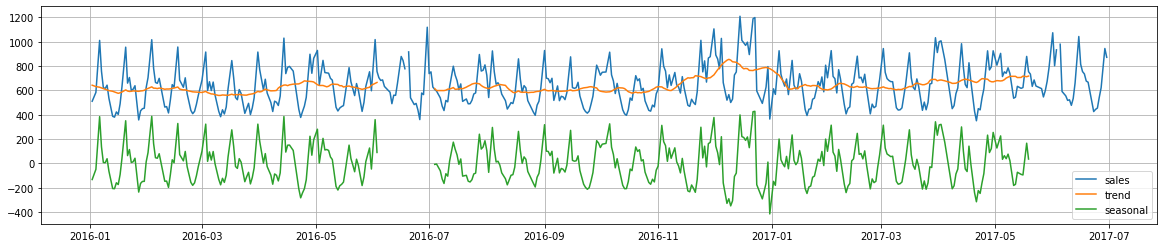

In [18]:
fig, ax = plt.subplots(figsize = (20, 4))

ax.plot(series, label = 'sales')
ax.plot(trend, label = 'trend')
ax.plot(seasonal, label = 'seasonal')
ax.grid()
ax.legend()

Вариант 3.

In [19]:
trend = series.rolling(365).mean()
detrend = series - trend

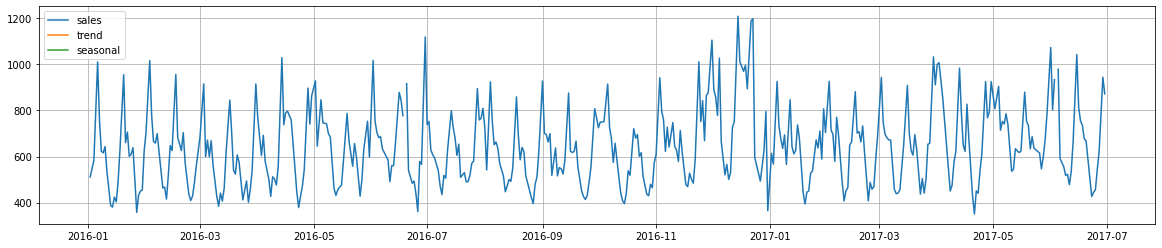

In [20]:
fig, ax = plt.subplots(figsize = (20, 4))

ax.plot(series, label = 'sales')
ax.plot(trend, label = 'trend')
ax.plot(detrend, label = 'seasonal')
ax.grid()
ax.legend()

Вариант 4.

In [21]:
xvalues = range(len(series))
z1 = np.polyfit(xvalues, series.fillna(0), deg = 1)

p1 = np.poly1d(z1)
trend = series - p1(series)

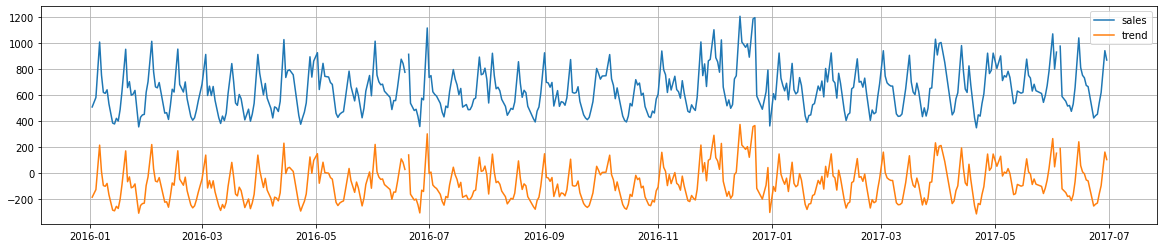

In [22]:
fig, ax = plt.subplots(figsize = (20, 4))

ax.plot(series, label = 'sales')
ax.plot(trend, label = 'trend')
ax.grid()
ax.legend()

### Ящичковые диаграммы

In [23]:
column = 19
tmp0 = pivot_data[column].reset_index(drop=False)
tmp0 = create_calendar_vars(tmp0, date_col ='dt')
tmp0

,dt,19,year,quarter,month,dayofyear,dayofmonth,dayofweek,week,is_weekend,week_of_month
0,2016-01-02,370.3,2016,1,1,2,2,5,53,True,1
1,2016-01-03,382.3,2016,1,1,3,3,6,53,True,1
2,2016-01-04,239.2,2016,1,1,4,4,0,1,False,2
3,2016-01-06,723.8,2016,1,1,6,6,2,1,False,2
4,2016-01-07,613.7,2016,1,1,7,7,3,1,False,2
...,...,...,...,...,...,...,...,...,...,...,...
448,2017-06-25,338.3,2017,2,6,176,25,6,25,True,4
449,2017-06-26,358.4,2017,2,6,177,26,0,26,False,5
450,2017-06-27,278.5,2017,2,6,178,27,1,26,False,5
451,2017-06-29,739.1,2017,2,6,180,29,3,26,False,5


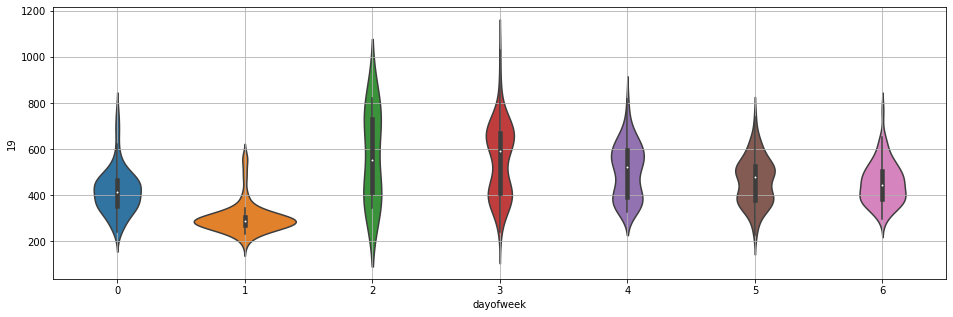

In [24]:
# 'year', 'quarter', 'month', 'dayofyear', 'dayofmonth', 'dayofweek', 'week', 'is_weekend', 'week_of_month'
fig, ax = plt.subplots(figsize=(16, 5))
sns.violinplot(data=tmp0, x="dayofweek", y=column, ax = ax)
ax.grid()

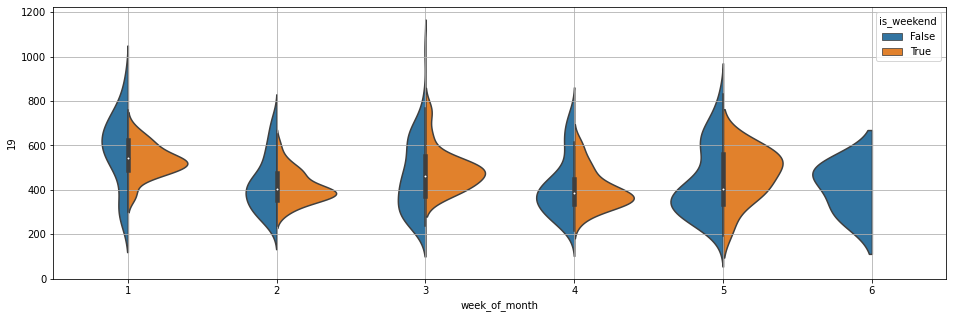

In [25]:
fig, ax = plt.subplots(figsize=(16, 5))
sns.violinplot(data=tmp0, x="week_of_month", y=column, hue="is_weekend", split=True, ax = ax)
ax.grid()

### Лаги

In [26]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

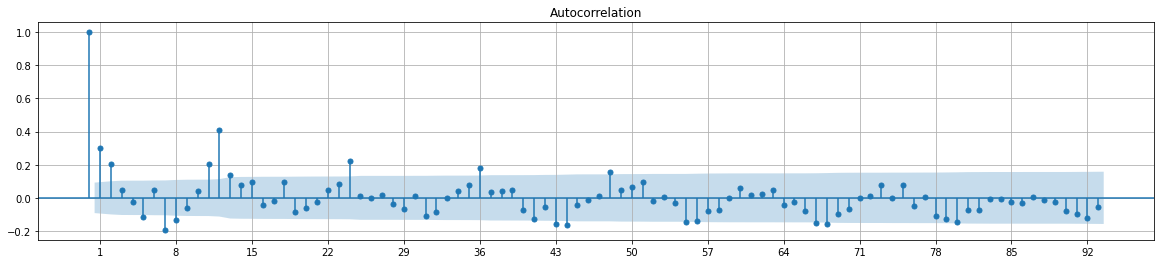

In [27]:
column = 19
tmp0 = pivot_data[column].fillna(0)

lags = 93
fig, ax = plt.subplots(figsize=(20, 4))
plot_acf(tmp0, lags = lags, ax=ax)
ax.xaxis.set_ticks(np.arange(1, lags, 7))
ax.grid();

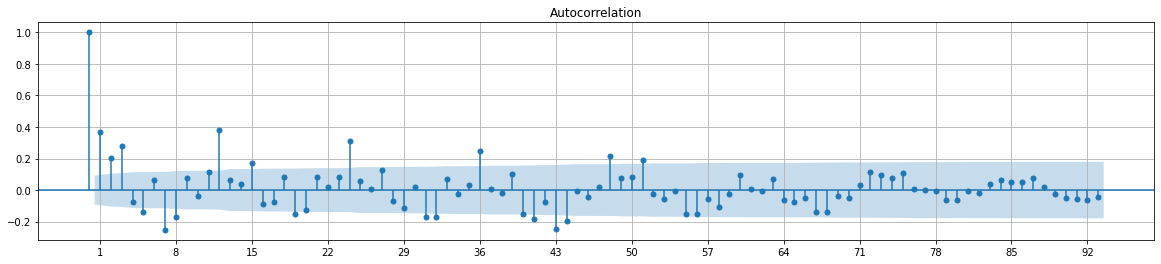

In [28]:
column = 0
tmp0 = pivot_data[column].fillna(0)

lags = 93
fig, ax = plt.subplots(figsize=(20, 4))
plot_acf(tmp0, lags = lags, ax=ax)
ax.xaxis.set_ticks(np.arange(1, lags, 7))
ax.grid();

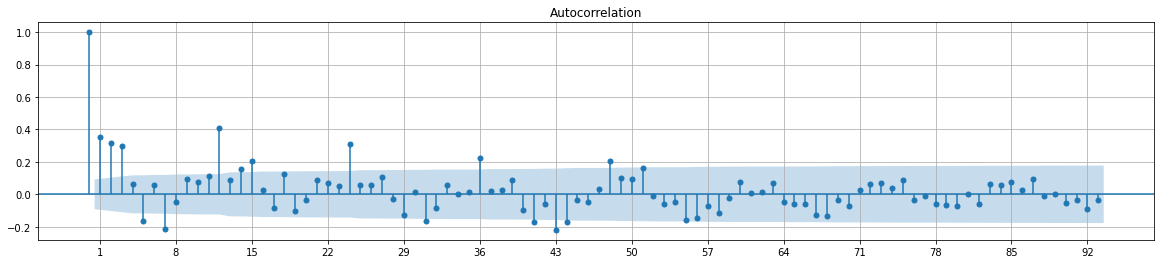

In [29]:
column = 1
tmp0 = pivot_data[column].fillna(0)

lags = 93
fig, ax = plt.subplots(figsize=(20, 4))
plot_acf(tmp0, lags = lags, ax=ax)
ax.xaxis.set_ticks(np.arange(1, lags, 7))
ax.grid();

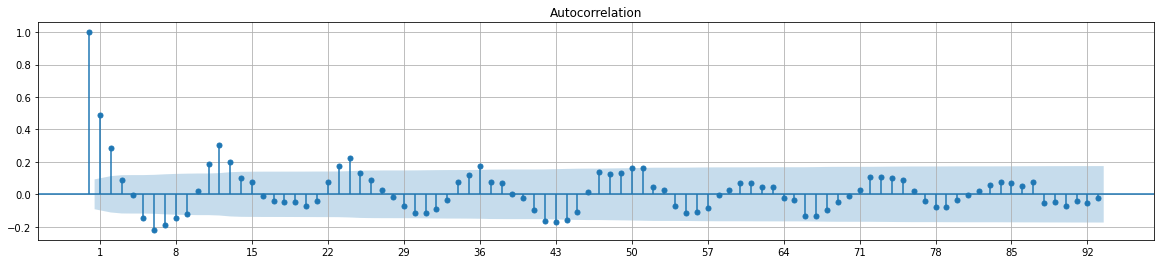

In [30]:
column = 5
tmp0 = pivot_data[column].fillna(0)

lags = 93
fig, ax = plt.subplots(figsize=(20, 4))
plot_acf(tmp0, lags = lags, ax=ax)
ax.xaxis.set_ticks(np.arange(1, lags, 7))
ax.grid();

1) Ряды содержат недельую сезонную компонету

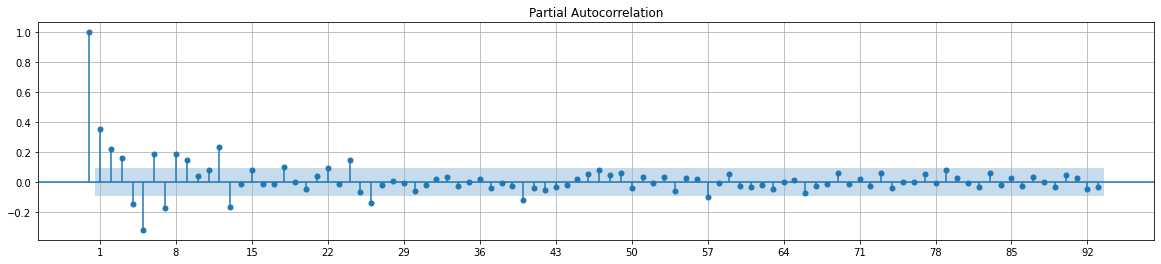

In [31]:
column = 1
tmp0 = pivot_data[column].fillna(0)

lags = 93
fig, ax = plt.subplots(figsize=(20, 4))
plot_pacf(tmp0, lags = lags, ax=ax)
ax.xaxis.set_ticks(np.arange(1, lags, 7))
ax.grid();

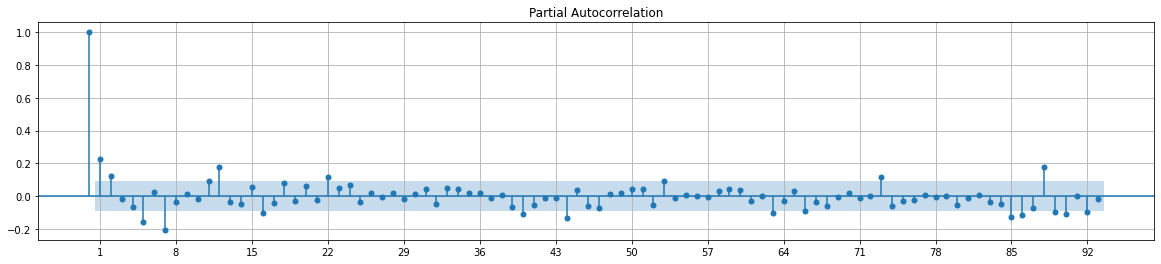

In [32]:
column = 2
tmp0 = pivot_data[column].fillna(0)

lags = 93
fig, ax = plt.subplots(figsize=(20, 4))
plot_pacf(tmp0, lags = lags, ax=ax)
ax.xaxis.set_ticks(np.arange(1, lags, 7))
ax.grid();

### Диаграммы рассеивания

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 12)'>

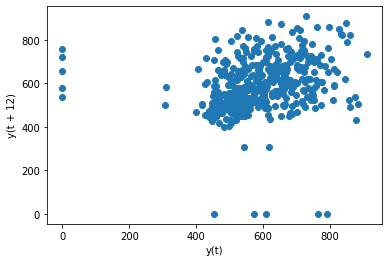

In [33]:
column = 2
tmp0 = pivot_data[column].fillna(0)

pd.plotting.lag_plot(tmp0, lag=12)

### Дифференцирование

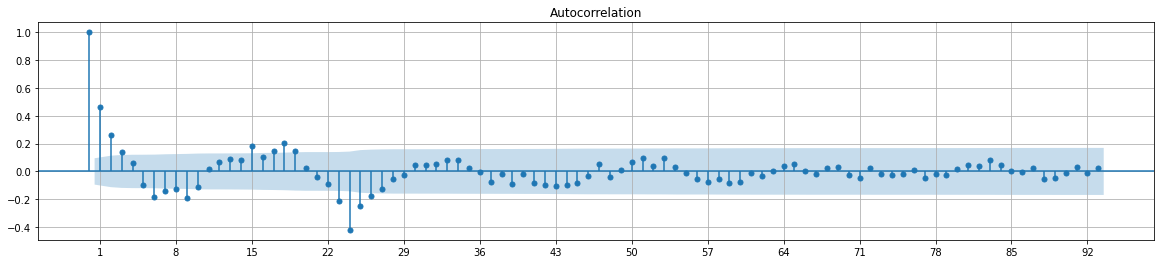

In [58]:
column = 5
tmp0 = pivot_data[column].fillna(0)
tmp0_diff_7 = tmp0.diff(24).dropna()

lags = 93
fig, ax = plt.subplots(figsize=(20, 4))
plot_acf(tmp0_diff_7, lags = lags, ax=ax)
ax.xaxis.set_ticks(np.arange(1, lags, 7))
ax.grid();

<AxesSubplot:xlabel='dt'>

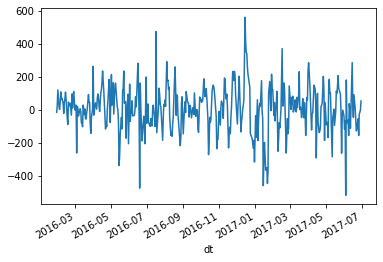

In [59]:
tmp0_diff_7.plot()

Нестационарный ряд с ярко выраженой сезооной компонеой.

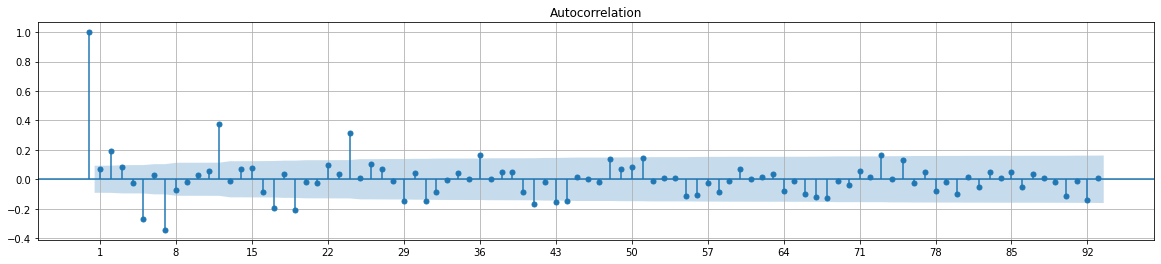

In [48]:
column = 3
tmp0 = pivot_data[column].fillna(0)


lags = 93
fig, ax = plt.subplots(figsize=(20, 4))
plot_acf(tmp0, lags = lags, ax=ax)
ax.xaxis.set_ticks(np.arange(1, lags, 7))
ax.grid();